In [3]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import gpytorch
from gpytorch.kernels import MaternKernel, ScaleKernel, \
RBFKernel, CosineKernel
from gpytorch.constraints import Positive

import matplotlib.pyplot as plt
import numpy as np

## Note: 
Define $\sigma: \mathbb{R} \rightarrow (0, \infty)$ by $$\sigma(t) = \frac{e^t}{1+e^t}$$

In [5]:
sigmoid = nn.Sigmoid()

## **Example 1:** 
Let $\theta \in \mathbb{R}^d$. For $j \in \{1, \ldots, n\}$, suppose that $x_j \overset{\text{iid}}{\sim} \text{Ber}(\sigma(\theta^T\theta)) $ 

In [6]:
# log-likelihood:

# input:
    #theta: px1 tensor of parameters 
    #x: nx1 tensor of binary data
    
# output:
    # nll_val: value of negative log likelihood for data x and params theta
        
def neg_avg_log_like(theta, x):
    p = sigmoid(torch.matmul(theta.t(), theta))
    nall = -torch.mean(x*torch.log(p) + (1-x)*torch.log(1-p))
    #nall = -torch.mean(x*torch.log(p) + (1-x)*torch.log(1-p))
    
    return nall
#------------------------------------------------------------------------------------------
#------------------------------------------------------------------------------------------


# log-likelihood on R^d/O(d):

# input:
    #t: 1x1 tensor containgin nonnegative real number parametrizing the orbit 
    #x: nx1 tensor of binary data
    
# output:
    # nll_val: value of negative log likelihood for data x on orbit of theta_t = t * e_1

def neg_avg_log_like_bar(t, x):
    p = sigmoid(t**2)
    nall = -torch.mean(x*torch.log(p) + (1-x)*torch.log(1-p))
    #nall = -torch.mean(torch.log(x*p + (1-x)*(1-p)))
    
    return nall

In [7]:
# set seed:
torch.manual_seed(0)

#dimensions
n = int(1e3) 
d = int(1e6)

# truth:
theta0 = torch.rand(d, 1) / (d**.5)
orb0 = torch.sqrt(torch.matmul(theta0.t(), theta0)) 

# probs:
p = sigmoid(torch.matmul(theta0.t(), theta0))
p = p.repeat(n, 1)

#data:
x = torch.bernoulli(p)

### Gradient Descent on $\mathbb{R}^d$

In [9]:
class FullModel(torch.nn.Module):
    def __init__(self, theta_init):
        super(FullModel, self).__init__()
        self.value = torch.nn.Parameter(theta_init)

    def neg_avg_log_like(self, x):
        p = sigmoid(torch.matmul(self.value.t(), self.value))
        nall = -torch.mean(x*torch.log(p) + (1-x)*torch.log(1-p))
        #nall = -torch.mean(x*torch.log(p) + (1-x)*torch.log(1-p))
        return nall
        
    def forward(self, x):
        return self.neg_avg_log_like(x)
    
    def get_orb(self):
        with torch.no_grad():
            res = torch.sqrt(torch.matmul(self.value.t(), self.value))
        return res
        



In [11]:
# set seed:
torch.manual_seed(0)
tkwargs = {"device":"cpu", "dtype":torch.double}
# optimization of negative log likelihood using sdg on R^d
theta_init = torch.randn(d, 1) / (d**.5)
theta = FullModel(theta_init)#
opt = torch.optim.SGD(theta.parameters(), lr=1e-3)

# likelihoods and distances
nalls1 = []
orb_dists1 = []

num_epochs = 5000
for epoch in range(num_epochs):
    opt.zero_grad()
    nall1 = theta(x)#neg_avg_log_like(theta, x)
    nall1.backward()
    opt.step() 

    if epoch % 500 == 0 :
        nalls1.append(nall1.item())
        orb1 = theta.get_orb()
        orb_dist1 = torch.abs(orb1.item() - orb0)
        orb_dists1.append(orb_dist1)
        print("epoch: %d" %  epoch)
        print("negative average log likelihood: %f" % nall1)
        print("orbit distance: %f" % orb_dist1)

#class NLL(nn.Module):
#    '''f : \mathbb{R}^p \righarrow \mathbb{R}''' 
#    def __init__(self, p):
#        super(NLL, self).__init__()

epoch: 0
negative average log likelihood: 0.704217
orbit distance: 0.422050
epoch: 500
negative average log likelihood: 0.685200
orbit distance: 0.325498
epoch: 1000
negative average log likelihood: 0.677291
orbit distance: 0.263068
epoch: 1500
negative average log likelihood: 0.673578
orbit distance: 0.220222
epoch: 2000
negative average log likelihood: 0.671682
orbit distance: 0.189581
epoch: 2500
negative average log likelihood: 0.670655
orbit distance: 0.167008
epoch: 3000
negative average log likelihood: 0.670073
orbit distance: 0.150011
epoch: 3500
negative average log likelihood: 0.669733
orbit distance: 0.137010
epoch: 4000
negative average log likelihood: 0.669529
orbit distance: 0.126948
epoch: 4500
negative average log likelihood: 0.669404
orbit distance: 0.119075


/home/felix/anaconda3/envs/btrch/lib/python3.7/site-packages/numpy/core/shape_base.py:65: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  ary = asanyarray(ary)
/home/felix/anaconda3/envs/btrch/lib/python3.7/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


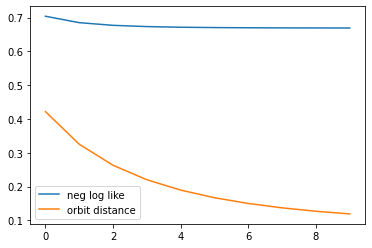

In [41]:
# plots
plt.plot(nalls1)
plt.plot(orb_dists1)
plt.legend(['neg log like', 'orbit distance'])

### Gradient Descent on $\mathbb{R}^d / O(d)$

In [12]:
class Radius(torch.nn.Module):
    def __init__(self, theta):
        super(Radius, self).__init__()
        tt = torch.sqrt(torch.matmul(theta.t(), theta))
        self.value = torch.nn.Parameter(tt)

    def neg_avg_log_like_bar(self, x):
        p = sigmoid(self.value**2)
        nall = -torch.mean(x*torch.log(p) + (1-x)*torch.log(1-p))
        return nall

    def forward(self, x):
        return self.neg_avg_log_like_bar(x)

In [13]:
# set seed:
torch.manual_seed(0)
theta = torch.randn(d, 1) / (d**.5)
# optimization of negative log likelihood using sdg on R^d using invariance
#theta = torch.randn(d, 1) / (d**.5)
#t = torch.sqrt(torch.matmul(theta.t(), theta))
#t.requires_grad = True
t = Radius(theta)
opt = torch.optim.SGD(t.parameters(), lr=1e-3)

# likelihoods and distances
nalls2 = []
orb_dists2 = []

num_epochs = 5000
for epoch in range(num_epochs):
    opt.zero_grad()
    nall2 = t(x)
    #nall2 = neg_avg_log_like_bar(t, x)
    #nall2.backward()
    nall2.backward()
    opt.step() 

    if epoch % 500 == 0:
        nalls2.append(nall2.item())
        orb2 = t.value
        orb_dist2 = torch.abs(orb2.item() - orb0)
        orb_dists2.append(orb_dist2)
        print("epoch: %d" %  epoch)
        print("negative average log likelihood: %f" % nall2)
        print("orbit distance: %f" % orb_dist2)

epoch: 0
negative average log likelihood: 0.704217
orbit distance: 0.422053
epoch: 500
negative average log likelihood: 0.685200
orbit distance: 0.325503
epoch: 1000
negative average log likelihood: 0.677292
orbit distance: 0.263076
epoch: 1500
negative average log likelihood: 0.673579
orbit distance: 0.220231
epoch: 2000
negative average log likelihood: 0.671682
orbit distance: 0.189583
epoch: 2500
negative average log likelihood: 0.670655
orbit distance: 0.167004
epoch: 3000
negative average log likelihood: 0.670073
orbit distance: 0.150008
epoch: 3500
negative average log likelihood: 0.669733
orbit distance: 0.137007
epoch: 4000
negative average log likelihood: 0.669529
orbit distance: 0.126940
epoch: 4500
negative average log likelihood: 0.669404
orbit distance: 0.119073


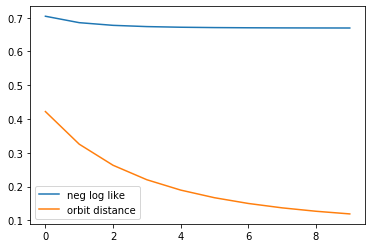

In [14]:
# plots
plt.plot(nalls2)
plt.plot(orb_dists2)
plt.legend(['neg log like', 'orbit distance'])

In [ ]:
# set seed:
torch.manual_seed(0)

#dimensions
n = 100 
ds = [1e1, 1e2, 1e3, 1e4, 1e5] #, 1e6, 1e7, 1e8, 1e9

# truth:
theta0s = [torch.rand(d, 1) for d in ds]
orb0 = [torch.sqrt(torch.matmul(theta0.t(), theta0)) for theta0 in theta0s]

# prob:
ps = [sigmoid(torch.matmul(theta0.t(), theta0) for theta0 in theta0s]
ps = [p.repeat(n, 1) for p in ps]

#data:
xs = [torch.bernoulli(p) for p in ps]

In [ ]:
# set seed:
torch.manual_seed(0)

for j in len(ds):
    # optimization of negative log likelihood using sgd on R^d
    theta = torch.randn(ds[j], 1, requires_grad=True)
    opt = torch.optim.SGD([theta], lr=0.01)

    # likelihoods and distances
    nlls = []
    orb_dists = []

    num_epochs = 100
    for epoch in range(num_epochs):
        if epoch % 10 == 0 :
            print("epoch: %d" %  epoch)
        
        nll = neg_log_like(theta, xs[])
        opt.zero_grad()
        nll.backward()
        opt.step() 

        if epoch % 10 == 0:
            nlls.append(nll.item())
            orb = torch.sqrt(torch.matmul(theta.t(), theta))
            orb_dist = torch.abs(orb.item() - orb0)
            orb_dists.append(orb_dist)

#class NLL(nn.Module):
#    '''f : \mathbb{R}^p \righarrow \mathbb{R}''' 
#    def __init__(self, p):
#        super(NLL, self).__init__()

In [88]:

p_hat = torch.sum(x)/n
torch.log(p_hat / (1 - p_hat))
orb1**2

tensor(0.2655)

tensor([[0.3463]], grad_fn=<PowBackward0>)

tensor([[0.3463]], grad_fn=<PowBackward0>)

tensor([[0.5857]], grad_fn=<SigmoidBackward0>)

In [89]:
p_hat
sigmoid(orb1**2)

tensor(0.5660)

tensor([[0.5857]], grad_fn=<SigmoidBackward0>)